# <font color='blue'>Data Science Academy</font>
# <font color='blue'>Big Data Real-Time Analytics com Python e Spark</font>

# <font color='blue'>Capítulo 11</font>

### *********** Atenção: *********** 
Utilize Java JDK 1.8 ou 11 e Apache Spark 2.4.2

****** Caso receba mensagem de erro "name 'sc' is not defined", interrompa o pyspark e apague o diretório metastore_db no mesmo diretório onde está este Jupyter notebook ******

## <font color='blue'>Spark MLLib - Regressão Linear</font>

<strong> Descrição </strong>
<ul style="list-style-type:square">
  <li>Método para avaliar o relacionamento entre variáveis.</li>
  <li>Estima o valor de uma variável dependente a partir dos valores das variáveis independentes.</li>
  <li>Usado quando as variáveis dependente e independente são contínuas e possuem alguma correlação.</li>
  <li>O R-Square mede quão perto os dados estão da linha de regressão. O valor do R-Squared será entre 0 e 1, sendo que quanto maior o valor, melhor.</li>
  <li>Os dados de entrada e de saída são usados na construção do modelo. A equação linear retorna os valores dos coeficientes.</li>
  <li>A equação linear representa o modelo.</li>
</ul>

<dl>
  <dt>Vantagens</dt>
  <dd>- Baixo custo</dd>
  <dd>- Veloz</dd>
  <dd>- Excelente para relações lineares</dd>
  <br />
  <dt>Desvantagens</dt>
  <dd>- Somente variáveis numéricas</dd>
  <dd>- Sensível a outliers</dd>
  <br />
  <dt>Aplicação</dt>
  <dd>- Um dos modelos mais antigos e pode ser usado para resolver diversos problemas</dd>
</dl>

## Usaremos Regressão Linear para prever os valores de MPG (Miles Per Gallon)

MPG será a variável target e as demais variáveis serão as features (variáveis preditoras).

In [1]:
# Imports
from pyspark.sql import Row
from pyspark.ml.linalg import Vectors
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

In [2]:
# Spark Session - usada quando se trabalha com Dataframes no Spark
spSession = SparkSession.builder.master("local").appName("DSA-SparkMLLib").getOrCreate()

In [3]:
# Carregando os dados e gerando um RDD
carrosRDD = sc.textFile("data/carros.csv")

In [4]:
# Colocando o RDD em cache. Esse processo otimiza a performance.
carrosRDD.cache()

data/carros.csv MapPartitionsRDD[1] at textFile at NativeMethodAccessorImpl.java:0

In [5]:
carrosRDD.count()

399

In [6]:
carrosRDD.take(5)

['MPG,CYLINDERS,DISPLACEMENT,HORSEPOWER,WEIGHT,ACCELERATION,MODELYEAR,NAME',
 '18,8,307,130,3504,12,70,chevrolet chevelle malibu',
 '15,8,350,165,3693,11.5,70,buick skylark 320',
 '18,8,318,150,3436,11,70,plymouth satellite',
 '16,8,304,150,3433,12,70,amc rebel sst']

In [7]:
# Removendo a primeira linha do arquivo (cabeçalho)
carrosRDD2 = carrosRDD.filter(lambda x: "DISPLACEMENT" not in x)
carrosRDD2.count()

398

## Limpeza dos Dados

In [8]:
carrosRDD2.take(398)

['18,8,307,130,3504,12,70,chevrolet chevelle malibu',
 '15,8,350,165,3693,11.5,70,buick skylark 320',
 '18,8,318,150,3436,11,70,plymouth satellite',
 '16,8,304,150,3433,12,70,amc rebel sst',
 '17,8,302,140,3449,10.5,70,ford torino',
 '15,8,429,198,4341,10,70,ford galaxie 500',
 '14,8,454,220,4354,9,70,chevrolet impala',
 '14,8,440,215,4312,8.5,70,plymouth fury iii',
 '14,8,455,225,4425,10,70,pontiac catalina',
 '15,8,390,190,3850,8.5,70,amc ambassador dpl',
 '15,8,383,170,3563,10,70,dodge challenger se',
 "14,8,340,160,3609,8,70,plymouth 'cuda 340",
 '15,8,400,150,3761,9.5,70,chevrolet monte carlo',
 '14,8,455,225,3086,10,70,buick estate wagon (sw)',
 '24,4,113,95,2372,15,70,toyota corona mark ii',
 '22,6,198,95,2833,15.5,70,plymouth duster',
 '18,6,199,97,2774,15.5,70,amc hornet',
 '21,6,200,85,2587,16,70,ford maverick',
 '27,4,97,88,2130,14.5,70,datsun pl510',
 '26,4,97,46,1835,20.5,70,volkswagen 1131 deluxe sedan',
 '25,4,110,87,2672,17.5,70,peugeot 504',
 '24,4,107,90,2430,14.5,70,

In [9]:
# Usando um valor padrão para average HP (que será usado para preencher os valores missing)
mediaHP = sc.broadcast(75.0)

In [10]:
# Função para limpeza dos dados
def limpaDados(inputStr) :
    global mediaHP
    attList = inputStr.split(",")
    
    # Substitui o caracter ? por um valor
    hpValue = attList[3]
    if hpValue == "?":
        hpValue = mediaHP.value
       
    # Cria uma linha usando a função Row, limpando e convertendo os dados de string para float
    linhas = Row(MPG = float(attList[0]), CYLINDERS = float(attList[1]), DISPLACEMENT = float(attList[2]), 
                 HORSEPOWER = float(hpValue), WEIGHT = float(attList[4]), ACCELERATION = float(attList[5]), 
                 MODELYEAR = float(attList[6]), NAME = attList[7]) 
    return linhas

In [11]:
# Executa a função no RDD
carrosRDD3 = carrosRDD2.map(limpaDados)
carrosRDD3.cache()
carrosRDD3.take(5)

[Row(ACCELERATION=12.0, CYLINDERS=8.0, DISPLACEMENT=307.0, HORSEPOWER=130.0, MODELYEAR=70.0, MPG=18.0, NAME='chevrolet chevelle malibu', WEIGHT=3504.0),
 Row(ACCELERATION=11.5, CYLINDERS=8.0, DISPLACEMENT=350.0, HORSEPOWER=165.0, MODELYEAR=70.0, MPG=15.0, NAME='buick skylark 320', WEIGHT=3693.0),
 Row(ACCELERATION=11.0, CYLINDERS=8.0, DISPLACEMENT=318.0, HORSEPOWER=150.0, MODELYEAR=70.0, MPG=18.0, NAME='plymouth satellite', WEIGHT=3436.0),
 Row(ACCELERATION=12.0, CYLINDERS=8.0, DISPLACEMENT=304.0, HORSEPOWER=150.0, MODELYEAR=70.0, MPG=16.0, NAME='amc rebel sst', WEIGHT=3433.0),
 Row(ACCELERATION=10.5, CYLINDERS=8.0, DISPLACEMENT=302.0, HORSEPOWER=140.0, MODELYEAR=70.0, MPG=17.0, NAME='ford torino', WEIGHT=3449.0)]

## Análise Exploratória de Dados

In [12]:
# Cria um Dataframe
carrosDF = spSession.createDataFrame(carrosRDD3)

In [13]:
# Estatísticas descritivas
carrosDF.select("MPG","CYLINDERS").describe().show()

+-------+-----------------+------------------+
|summary|              MPG|         CYLINDERS|
+-------+-----------------+------------------+
|  count|              398|               398|
|   mean|23.51457286432161| 5.454773869346734|
| stddev|7.815984312565782|1.7010042445332125|
|    min|              9.0|               3.0|
|    max|             46.6|               8.0|
+-------+-----------------+------------------+



In [14]:
# Encontrando a correlação entre a variável target com as variáveis preditoras
for i in carrosDF.columns:
    if not(isinstance(carrosDF.select(i).take(1)[0][0], str)) :
        print("Correlação da variável MPG com", i, carrosDF.stat.corr('MPG', i))

Correlação da variável MPG com ACCELERATION 0.42028891210165004
Correlação da variável MPG com CYLINDERS -0.7753962854205548
Correlação da variável MPG com DISPLACEMENT -0.8042028248058979
Correlação da variável MPG com HORSEPOWER -0.774704152349872
Correlação da variável MPG com MODELYEAR 0.5792671330833091
Correlação da variável MPG com MPG 1.0
Correlação da variável MPG com WEIGHT -0.8317409332443347


## Pré-Processamento dos Dados

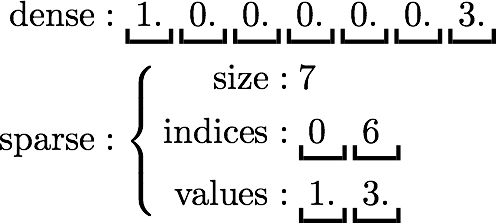

In [15]:
from IPython.display import Image
Image("imagens/vetores.png")

Vetores esparsos são vetores que tem muitos valores como zero. Enquanto um vetor denso é quando a maioria dos valores no vetor são diferentes de zero.

Conceitualmente são o mesmo objeto. Apenas um vetor. Normalmente, o vetor esparso é representado por uma tupla (id, valor).

Por exemplo, um vetor denso (1, 2, 0, 0, 5, 0, 9, 0, 0) seria representado como vetor esparso assim: {(0,1,4,6), (1, 2, 5, 9)}

In [16]:
# Convertendo para um LabeledPoint (target, Vector[features])
# Remove colunas não relevantes para o modelo ou com baixa correlação
def transformaVar(row) :
    obj = (row["MPG"], Vectors.dense([row["ACCELERATION"], row["DISPLACEMENT"], row["WEIGHT"]]))
    return obj

In [17]:
# Utiliza o RDD, aplica a função, converte para Dataframe e aplica a função select()
carrosRDD4 = carrosRDD3.map(transformaVar)
carrosDF = spSession.createDataFrame(carrosRDD4,["label", "features"])
carrosDF.select("label","features").show(10)

+-----+-------------------+
|label|           features|
+-----+-------------------+
| 18.0|[12.0,307.0,3504.0]|
| 15.0|[11.5,350.0,3693.0]|
| 18.0|[11.0,318.0,3436.0]|
| 16.0|[12.0,304.0,3433.0]|
| 17.0|[10.5,302.0,3449.0]|
| 15.0|[10.0,429.0,4341.0]|
| 14.0| [9.0,454.0,4354.0]|
| 14.0| [8.5,440.0,4312.0]|
| 14.0|[10.0,455.0,4425.0]|
| 15.0| [8.5,390.0,3850.0]|
+-----+-------------------+
only showing top 10 rows



In [18]:
carrosRDD4.take(5)

[(18.0, DenseVector([12.0, 307.0, 3504.0])),
 (15.0, DenseVector([11.5, 350.0, 3693.0])),
 (18.0, DenseVector([11.0, 318.0, 3436.0])),
 (16.0, DenseVector([12.0, 304.0, 3433.0])),
 (17.0, DenseVector([10.5, 302.0, 3449.0]))]

## Machine Learning

In [19]:
# Dados de Treino e de Teste
(dados_treino, dados_teste) = carrosDF.randomSplit([0.7, 0.3])

In [20]:
dados_treino.count()

296

In [21]:
dados_teste.count()

102

In [22]:
# Treinamento e criação do modelo
linearReg = LinearRegression(maxIter = 10)
modelo = linearReg.fit(dados_treino)

In [23]:
print(modelo)

LinearRegression_e0448a5595da


In [24]:
# Imprimindo as métricas
print("Coeficientes: " + str(modelo.coefficients))
print("Intercepto: " + str(modelo.intercept))

Coeficientes: [0.2275914519326297,-0.011529922814702413,-0.006087116913074124]
Intercepto: 40.38338961793662


In [25]:
# Previsões com dados de teste
predictions = modelo.transform(dados_teste)
predictions.select("features", "prediction").show()

+-------------------+------------------+
|           features|        prediction|
+-------------------+------------------+
|[14.0,400.0,4997.0]| 8.540377604481073|
|[11.0,455.0,4951.0]| 7.503464871875963|
|[12.5,350.0,4499.0]|11.806870790028167|
|[13.5,350.0,4456.0]| 12.29620826922298|
|[11.0,360.0,3821.0]| 15.47724965104645|
|[12.0,302.0,3169.0]| 20.34237685355615|
|[13.0,350.0,3988.0]|15.031183258575357|
|[13.0,360.0,4654.0]|10.861864166320967|
| [8.5,440.0,4312.0]| 10.99710279171929|
|[13.0,351.0,4129.0]|14.161369851017202|
|[13.5,351.0,4154.0]|14.122987654156663|
|[11.5,350.0,3693.0]|16.485495570033276|
|[13.5,318.0,4135.0]|14.619130328390252|
|[19.0,258.0,3730.0]| 19.02796103269688|
|[11.5,400.0,4668.0]| 9.974060439050888|
|[18.0,258.0,3632.0]|19.396907038245516|
|[18.5,250.0,3897.0]|17.989856164764806|
|[14.5,171.0,2984.0]| 23.54789200103245|
|[14.5,250.0,3139.0]| 21.69352497714447|
|[16.0,232.0,2945.0]|23.423351446844443|
+-------------------+------------------+
only showing top

In [26]:
# Coeficiente de determinação R2
avaliador = RegressionEvaluator(predictionCol = "prediction", labelCol = "label", metricName = "r2")
avaliador.evaluate(predictions) 

0.690903363388816

# Fim

### Obrigado - Data Science Academy - <a href="http://facebook.com/dsacademybr">facebook.com/dsacademybr</a>